## 获取数据
使用BLOCKCHAIN API获得数据

将获得数据并存储为CSV文件

In [56]:
import csv, requests, re
setup = {'timespan' : '35months' , 'format' : 'csv' } 
bitcoin_data = requests.get('https://api.blockchain.info/charts/market-price?', params = setup)
# 展示合成url 
# print( bitcoin_data.url)

# print data
# bitcoin_data.text

# 查找编码属性
# bitcoin_data.encoding (uttf-8)

# 生成文件
with open('/Users/zhangxinwan/where_paper/paper_prepare/bitcoin_data.csv' , 'w') as f:
    f.write('TIME,USD\n' + bitcoin_data.text)

 ## 读取数据
 
 **数据分拨**
 
 选出训练数据及验证数据 
 1. 前30月数据为建模数据
 2. 后5月数据为真实数据与预测数据对比
 
 差分
 > 就是求时间序列\{r_t\}在t时刻的值r_t与t−1时刻的值r_{t−1}的差d_t，则我们得到了一个新序列\{d_t\}，为一阶差分，对新序列\{d_t\}再做同样的操作，则为二阶差分。通常非平稳序列可以经过d次差分，处理成弱平稳或者近似弱平稳时间序列
 

                USD
count   1050.000000
mean    4654.814307
std     3713.405201
min      515.061900
25%     1128.342332
50%     3968.090417
75%     6645.086042
max    19498.683333


/Users/zhangxinwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhangxinwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


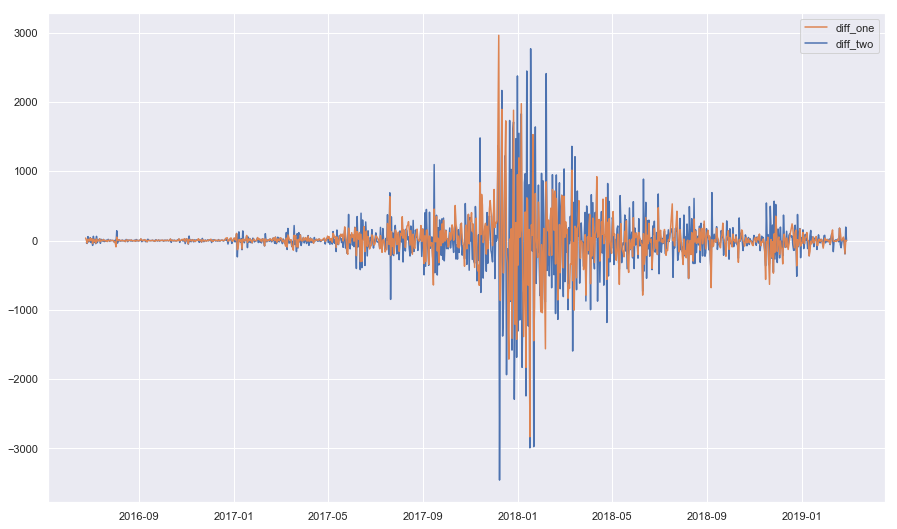

In [6]:
# 读取数据
# 数据分拨 选出训练数据及验证数据 
from scipy import stats
# 统计相关的库
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm  
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
#导入中文字体，避免显示乱码
import pylab as mpl  

usd_time = pd.read_csv('/Users/zhangxinwan/where_paper/paper_prepare/bitcoin_data.csv')
whole_data = usd_time 

# 描述性统计
# print(usd_time)
print(usd_time.dropna().describe()) 

# 行数与列数
# usd_time.shape (350, 1)

# 时间排序
# usd_time.sort_values(by='TIME')

# 展示全数据图表

# 分数据
usd_time = whole_data.loc[:979, :]
usd_time['TIME']= pd.to_datetime(usd_time['TIME'])
true_result = whole_data.loc[980:, :]
true_result['TIME']= pd.to_datetime(true_result['TIME'])
# print(true_result)
# print(usd_time.head())

# x轴数据
x = usd_time['TIME']

# y轴数据
y = usd_time['USD']

# 背景网格
sns.set(style="darkgrid")

fig = plt.figure(figsize = (15,9))

# 全数据一阶差分与二阶差分展示
usd_time['USD'].diff()
diff = usd_time['USD'].diff()
# 一阶
diff_one = diff
# 二阶
diff = diff.diff()
diff_two = diff
# 三阶差分 

l2, = plt.plot(x, diff_two)
l1, = plt.plot(x, diff_one)

plt.legend(handles=[l1, l2], labels=['diff_one', 'diff_two'])
# 时间序列数组
# print(usd_time['TIME'].values)
# print(usd_time['USD'].values)
# 返回数据类型为数字

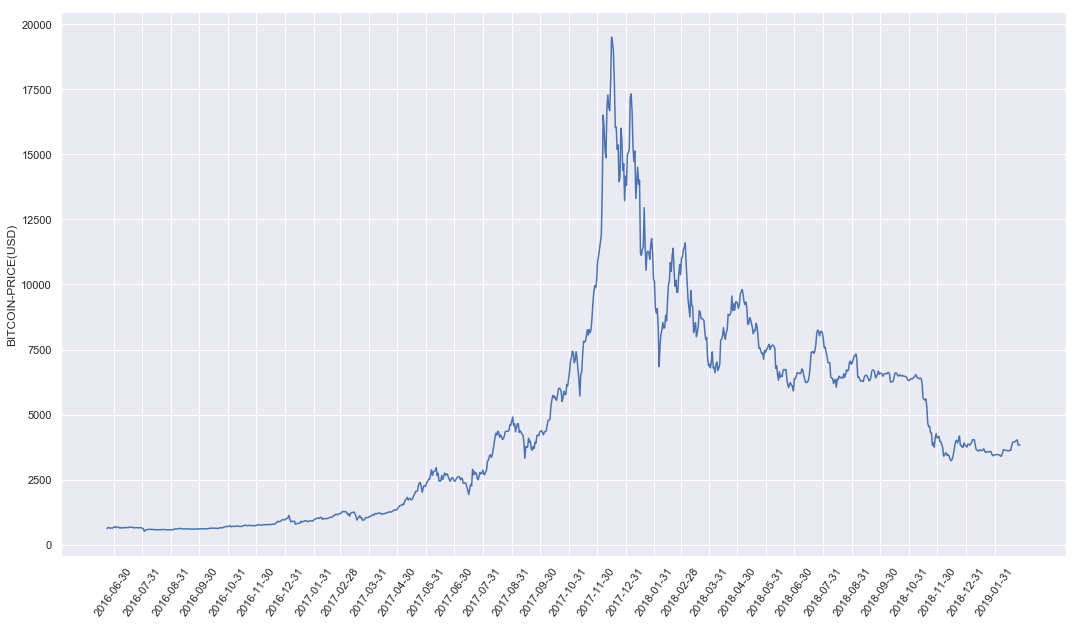

In [7]:
'''选取数据进行平稳性检验的训练数据
'''

# plot the data
# figsize 表格相关设置
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(1, 1, 1)

#设置x轴的时间格式
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
ax.xaxis_date()
'''时间间隔是10天
   设置x轴坐标值和标签旋转45°的显示方式
'''
plt.xticks(pd.date_range(x[0],x.values[-1],freq='1M'),rotation=55)

# x轴 y轴 名称
plt.ylabel('BITCOIN-PRICE(USD)')
ax.plot(x, y)
plt.show()

## 宽平稳
> 若时间序列\{r_t\}满足下面两个条件：E(r_t)=\mu，\mu是常数Cov(r_t,r_{t-l}) = \gamma _l，\gamma _l只依赖于l则时间序列\{r_t\}为弱平稳的。即该序列的均值，r_t与r_{t−l}的协方差不随时间而改变，l为任意整数。
## ADFuller Test
>  P-value是否小于0.05，小于则拒绝假设，平稳

> 1%、5%、10%不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设
ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设

## KPSS Test
> P-Value是否大于0.05，大于则假设成立，平稳

> 10%、5%、2.5%, 1%不同程度拒绝原假设的统计值和（-------------）的比较，kpss-statistics同时小于即说明非常好地拒绝该假设

## 结论
* ADF  不平稳
* KPSS 不平稳
* ADF 一阶 平稳
* KPSS 一阶  平稳
* ADF 二阶 平稳
* KPSS 二阶 平稳

 - [ ] 寻找引用论文
Using Time-Series and Sentiment Analysis to detect the Determinants of Bitcoin Prices
> First, we study the stationarity of each series by using the ADF, the PP and the KPSS tests. Since the ADF test yields ambiguous results concerning the stationarity of some independent variables, we turn to the PP unit root test which uses the Newey-West HAC standard errors to account for serial correlation. The results are summarized in Table 3 which shows the PP test statistic and the associated p-value for all series as well as for the first differences of nonstationary series. We conclude that the variables logbcp, logtotbc, logsp and logexrate are I(1), whereas for all other variables the null hypothesis of a unit root is rejected. These results are verified by the KPSS test having the opposite null hypothesis of stationarity

In [8]:
# ADF测试 
adf_test_ct = ts.adfuller(usd_time['USD'], regression='ct', autolag='AIC')
adf_test_c = ts.adfuller(usd_time['USD'], regression='c', autolag='AIC')
adf_test_nc = ts.adfuller(usd_time['USD'], regression='nc', autolag='AIC')
#分隔
print('----ct----')
print(adf_test_ct)
#分隔
print('----c----')
print(adf_test_c)
#分隔
print('----nc----')
print(adf_test_nc)

# 此时第二个数字 p_value 大于 0.05 因此序列不平稳

diff_one = diff_one.dropna()
diff_two = diff_two.dropna()
diff_one_adf = ts.adfuller(diff_one, regression='ct', autolag='AIC')
diff_two_adf = ts.adfuller(diff_two, regression='ct', autolag='AIC')

# print(diff_one)
# e-08 代表小数点后有 7 个 0 因此一阶差分已经平稳

#分隔
print('----diff_one_adf_ct----')
print(diff_one_adf)
#分隔
print('----diff_two_adf_ct----')
print(diff_two_adf)

# KPSS测试

kpss_test = ts.kpss(usd_time['USD'], regression='ct')
diff_one_kpss = ts.kpss(diff_one, regression='ct')
diff_two_kpss = ts.kpss(diff_two, regression='ct')
#分隔
print('----kpss_ct----')
print(kpss_test)
#分隔
print('----diff_one_kpss_ct----')
print(diff_one_kpss)
#分隔
print('----diff_two_kpss_ct----')
print(diff_two_kpss)

----ct----
(-2.158258723037972, 0.5133588189496253, 22, 957, {'1%': -3.9682610677228047, '5%': -3.4150875878258837, '10%': -3.129756087559827}, 13651.878023670692)
----c----
(-2.0724989792248794, 0.25571568840084563, 22, 957, {'1%': -3.4372015433243797, '5%': -2.8645648359053517, '10%': -2.568380590610461}, 13650.600333569615)
----nc----
(-1.1190789975996256, 0.23882105882580001, 22, 957, {'1%': -2.56808021940298, '5%': -1.9412843073193133, '10%': -1.6165454004714126}, 13651.762407813727)
----diff_one_adf_ct----
(-5.094327153301748, 0.0001380495009054134, 21, 957, {'1%': -3.9682610677228047, '5%': -3.4150875878258837, '10%': -3.129756087559827}, 13641.425774702471)
----diff_two_adf_ct----
(-13.431943839949096, 4.120450640784456e-21, 20, 957, {'1%': -3.9682610677228047, '5%': -3.4150875878258837, '10%': -3.129756087559827}, 13652.407997199338)
----kpss_ct----
(0.6134543427371478, 0.01, 22, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
----diff_one_kpss_ct----
(0.0673648724976

/Users/zhangxinwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/Users/zhangxinwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/zhangxinwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## ACF/PACF
the use of acf/pacf
> particularly the residual ACF and PACF plots,
to see if all coefficients are significant and all of the pattern
has been explained. 
> Patterns that remain in the ACF and PACF may suggest the
need for additional AR or MA terms

拖尾和截尾
>  拖尾指序列以指数率单调递减或震荡衰减，而截尾指序列从某个时点变得非常小：



二阶差分图
* 震荡
* 趋势

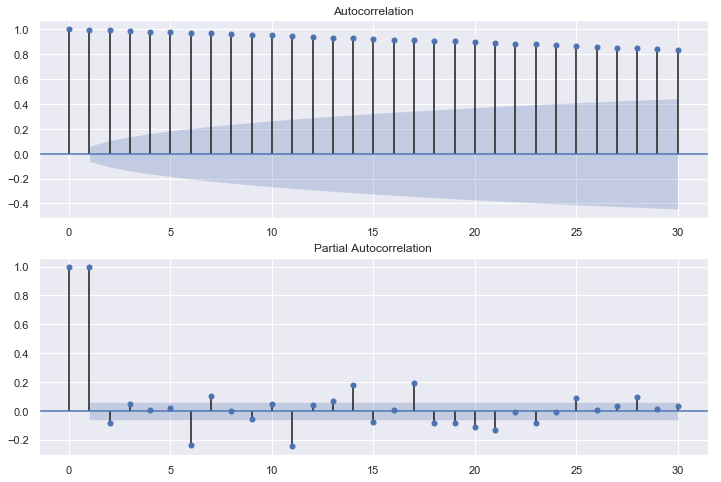

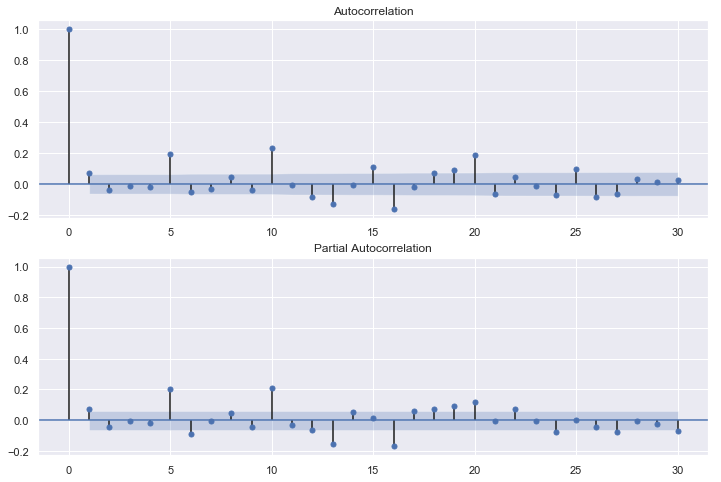

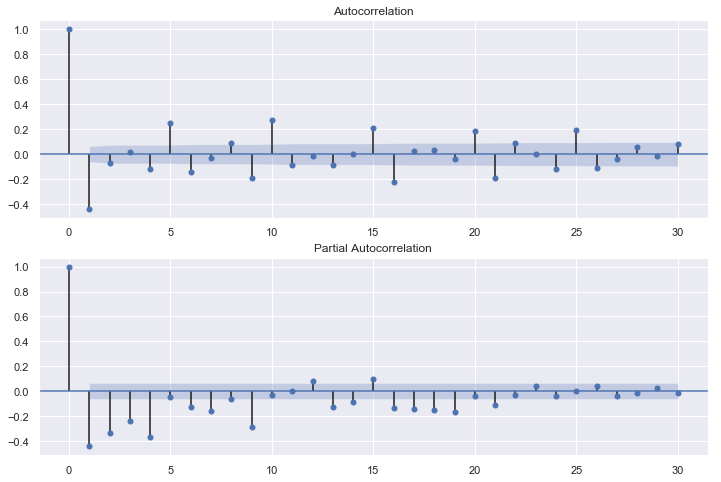

In [9]:
# diff_one_acf = ts.acf(diff_one)
# print(diff_one_acf)

# 自相关与偏自相关
fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=30, ax=ax2)

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_one, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_one, lags=30, ax=ax2)

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_two, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_two, lags=30, ax=ax2)

plt.show()
 

## AIC/BIC准则定阶
一阶差分

AIC (13, 7)
BIC (13, 7)

In [10]:
# AIC/BIC
# 需要处理diff_one 
# diff_one.values
# order = ts.arma_order_select_ic(diff_one.values,max_ar = 6,max_ma = 6,ic = ['aic','bic'])

# order = ts.arma_order_select_ic(diff_one.values,max_ar = 15,max_ma = 15,ic = ['aic','bic'])
# print('AIC', order.aic_min_order)
# print('BIC', order.bic_min_order)

In [11]:
# print(diff_one)
# 模拟 ARIMA
arima_one_result = ARIMA(usd_time['USD'], order=(13,1,7)).fit(disp=-1, method = 'css-mle')
summary = arima_one_result.summary2(alpha=.05, float_format="%.8f")
print(summary)

# arima_one_formula = ARIMA(diff_one, order=(13,1,7)).score(params = arima_one_params)
# print(arima_one_formula)

                           Results: ARIMA
Model:              ARIMA            BIC:                 14031.4583
Dependent Variable: D.USD            Log-Likelihood:      -6940.0   
Date:               2019-06-10 23:38 Scale:               1.0000    
No. Observations:   979              Method:              css-mle   
Df Model:           21               Sample:              1         
Df Residuals:       958                                   0         
Converged:          1.0000           S.D. of innovations: 289.523   
No. Iterations:     164.0000         HQIC:                13964.856 
AIC:                13923.9546                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025    0.975]
---------------------------------------------------------------------
const            3.2539   11.1247   0.2925  0.7700  -18.5501  25.0579
ar.L1.D.USD     -0.2712    0.0921  -2.9439  0.0033   -0.4

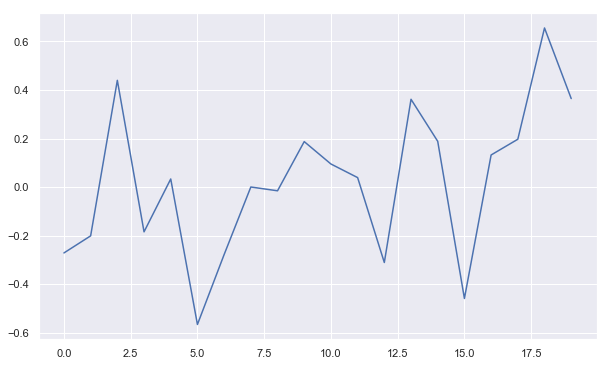

In [14]:
# params show
arima_one_arparams = arima_one_result.arparams
arima_one_maparams = arima_one_result.maparams
arima_one_params = np.append(arima_one_arparams, arima_one_maparams)
fig = plt.figure(figsize=(10, 6))
plt.plot(arima_one_params)

 ## Results: ARIMA

1. 

————————————————————————————————————————————————————————————————————


2. 
coef -- 参数 系数

std.err -- 标准错误差

t -- 

p-value -- 小于5%

coef置信区间 -- 

————————————————————————————————————————————————————————————————————

## 残差序列是否满足白噪音

模拟(13,1,7)的序列残差

* ADF p = 0 相当平稳 

* acf/pacf plot

残差即： 预测值与实际值的差值
plot :查看残差的正态分布


                               value
Test Statistic Value        -31.1906
p-value                            0
Lags Used                          0
Number of Observations Used      978
Critical Value(1%)          -3.96806
Critical Value(5%)          -3.41499
Critical Value(10%)          -3.1297


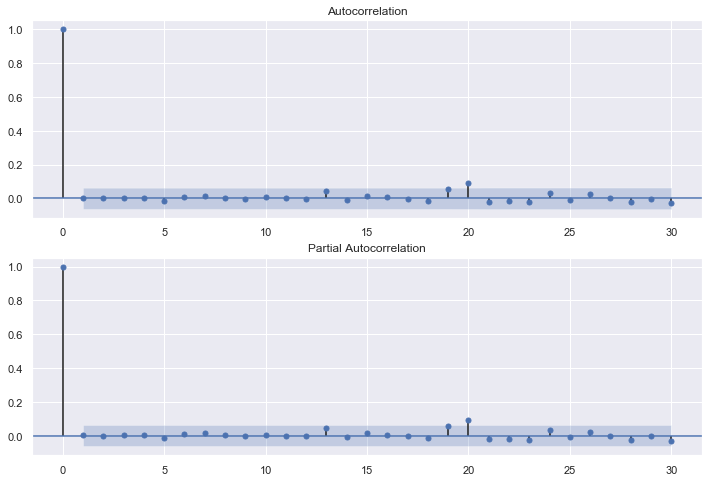

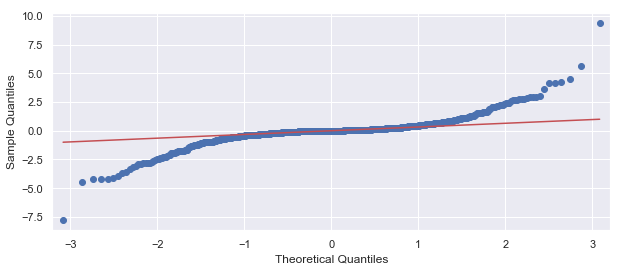

In [61]:
# resid
arima_one_result_resid = arima_one_result.resid
adf_resid_one_ct = ts.adfuller(arima_one_result_resid, regression='ct', autolag='AIC')

# 输出格式解析
t = adf_resid_one_ct
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

# 自相关与偏自相关
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_one_result_resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_one_result_resid , lags=30, ax=ax2)

from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
fig = qqplot(arima_one_result_resid, line='q', ax=ax, fit=True)

## 预测
*得出差分预测需要逆差分还原*

[0.95766251 0.99825059 0.9997186  0.99994328 0.99882871 0.99946144
 0.99949199 0.99986312 0.99996562 0.99998828 0.99999742 0.99999932
 0.99940061 0.99972065 0.99983194 0.9999268  0.99997065 0.99998109
 0.99833042 0.83577722 0.85553179 0.88068447 0.89588975 0.88807076
 0.9100941  0.91696722 0.93740252 0.94481062 0.95915356 0.95827506]


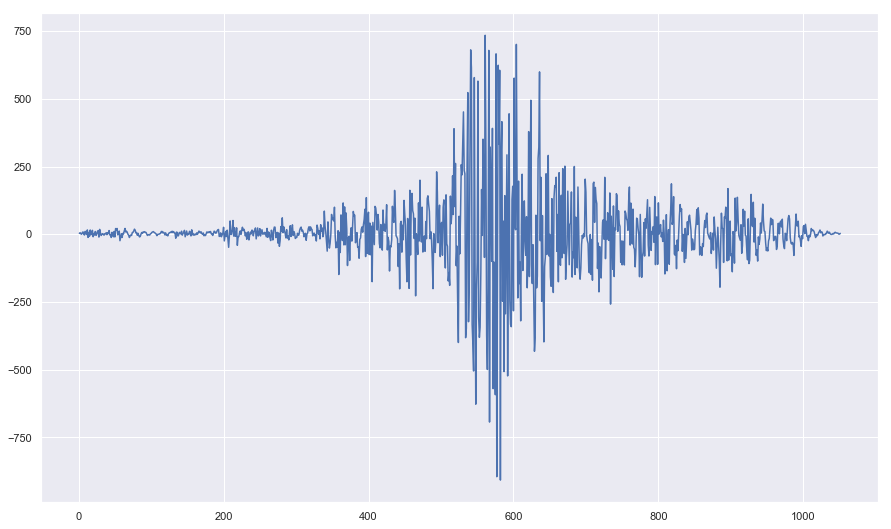

In [62]:
predict_one = arima_one_result.predict(start = 1 ,end = 1051)                                      
# print(predict_one)
fig = plt.figure(figsize = (15,9))
plt.plot(predict_one)

from statsmodels.stats.diagnostic import acorr_ljungbox
p_value = acorr_ljungbox(arima_one_result_resid, lags=30)[1]
print(p_value)

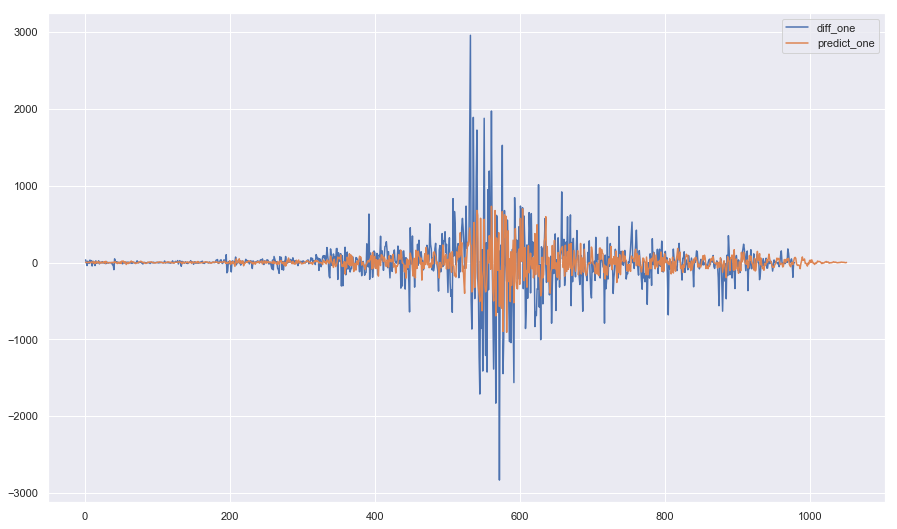

In [63]:
# print(diff_one)
fig = plt.figure(figsize = (15,9))
l1, = plt.plot(diff_one)
l2, = plt.plot(predict_one)
plt.legend(handles=[l1, l2], labels=['diff_one', 'predict_one'])

In [64]:
# 一阶差分还原
predict_one_shift = predict_one.shift(1) 
predict_one_shift = predict_one_shift.fillna(0)
# print(predict_one_shift)
# predict_one_shift[0] = int(0)

# USD原值下降一行
ordinary = usd_time['USD'].shift(1)
ordinary = ordinary.fillna(usd_time['USD'][0]) 
# print(predict_one_shift)

# diff_one_recover = usd_time['USD'].add(predict_one_shift)
# 原始数据取对数
# y_log = np.log(usd_time['USD'])
# print(y_log)
#------------------------------------------
########## ndarray内含 
########## 0值后形成新的数据结构 
########## 0值变为NaN
#------------------------------------------
# 双数组循环
# 最终预测值
whole_data_df = {'ordinary' : ordinary, 'predict': predict_one} 
whole_data_df = pd.DataFrame(data = whole_data_df)
whole_data_df = whole_data_df.fillna(0)
# print(predict_one)
# whole_data['TIME'] time data

for i,r in whole_data_df.iterrows():
    if whole_data_df.loc[i, 'ordinary'] == 0:
        whole_data_df.loc[i, 'ordinary'] =  whole_data_df.loc[i-1, 'ordinary'] + whole_data_df.loc[i, 'predict']
    else:
        continue
print(whole_data_df)

diff_one_re = pd.DataFrame()

# diff_one_re = whole_data_df['ordinary'].add(whole_data_df['predict'])
# huge mistake
# re-diff
diff_one_re = whole_data_df['ordinary']

print(diff_one_re)
# print(ordinary)
# diff_one_re = predict_one_shift.add(ordinary)
# print(diff_one_re) 

         ordinary    predict
0      624.542000   0.000000
1      624.542000   3.253922
2      660.604650   5.587192
3      664.906888   1.866029
4      627.392613  -0.084834
5      646.703012   5.606234
6      646.378475   8.693354
7      637.959625   1.246056
8      671.407925  -2.776355
9      675.186338  10.476884
10     701.712112   2.529582
11     658.417500  -1.030751
12     676.329438  15.935167
13     666.485587 -11.794928
14     673.786825   6.572911
15     636.358862  -7.311445
16     659.555237  15.602697
17     651.864912  -1.526688
18     648.094900   1.152862
19     647.983700  14.430191
20     672.765312  -9.295021
21     657.452487   2.334196
22     658.831613  -2.616619
23     664.571450  10.181191
24     662.153350  -4.182484
25     675.459050   0.580481
26     673.205637  10.101782
27     672.843200  13.280986
28     665.643125 -10.564128
29     664.882075  17.909044
...           ...        ...
1022  3944.206722   9.441977
1023  3959.769300  15.562578
1024  3965.120

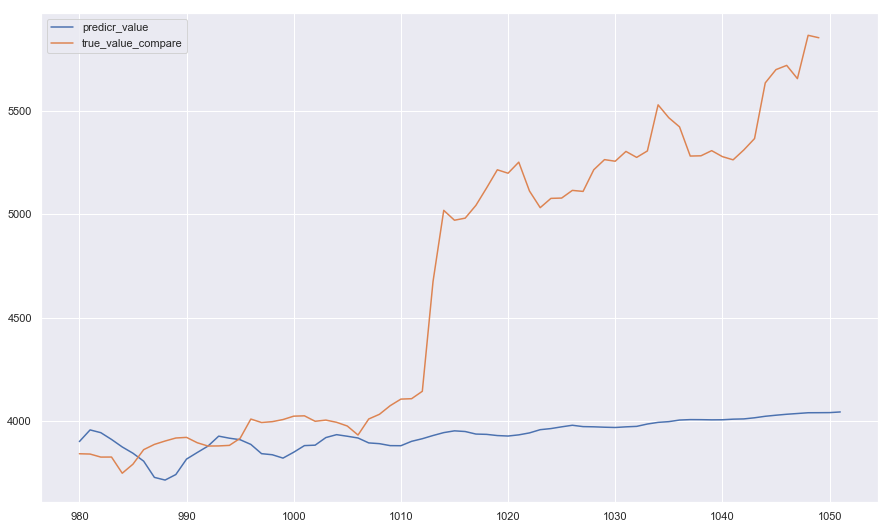

In [55]:

# diff_one_re_part = whole_data_df['ordinary'].loc[980:]
# # 拟合展示
# fig = plt.figure(figsize = (15,9))
# l2, = plt.plot(diff_one_re_part)
# l3, = plt.plot(true_result['USD'])
# plt.legend(handles=[l2, l3], labels=['predicr_value', 'true_value_compare'])

diff_one_re_part = diff_one_re.loc[980:]
# diff_one_re_part = whole_data_df['ordinary'].loc[980:]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(diff_one_re_part)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l2, l3], labels=['predicr_value', 'true_value_compare'])

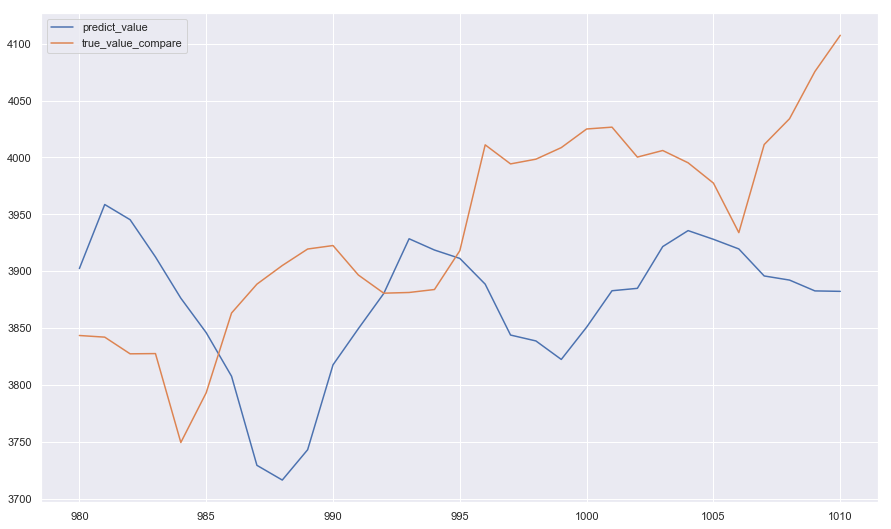

In [56]:
diff_one_re_part = diff_one_re.loc[980:1010]
true_result_slice = true_result['USD'].loc[980:1010]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(diff_one_re_part)
l3, = plt.plot(true_result_slice)
plt.legend(handles=[l2, l3], labels=['predict_value', 'true_value_compare'])

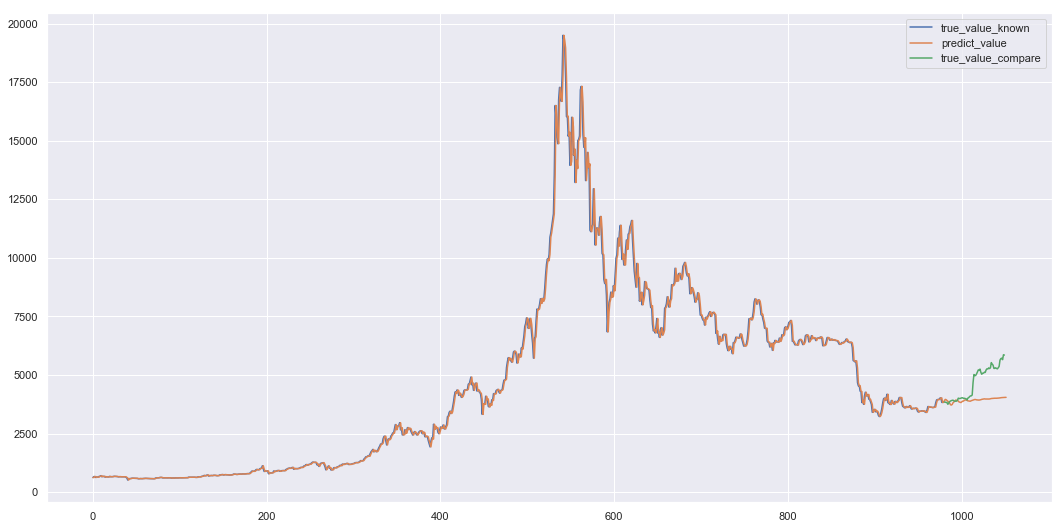

In [57]:
fig = plt.figure(figsize = (18,9))
l1, = plt.plot(y)
l2, = plt.plot(diff_one_re)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l1, l2, l3], labels=['true_value_known', 'predict_value', 'true_value_compare'])

### 二阶差分

AIC (15, 13)

BIC (13, 8)

In [28]:
# # 二阶差分 AIC/BIC
# order_second = ts.arma_order_select_ic(diff_two.values,max_ar = 15,max_ma = 15,ic = ['aic','bic'])
# print('AIC', order_second.aic_min_order)
# print('BIC', order_second.bic_min_order)

In [29]:
arima_two_aic_result = ARIMA(usd_time['USD'], order=(15,2,13)).fit(disp=-1, method = 'css-mle')
summary_ta = arima_two_aic_result.summary2(alpha=.05, float_format="%.8f")
print(summary_ta)
arima_two_bic_result = ARIMA(usd_time['USD'], order=(13,2,8)).fit(disp=-1, method = 'css-mle')
summary_tb = arima_two_bic_result.summary2(alpha=.05, float_format="%.8f")
print(summary_tb)

                           Results: ARIMA
Model:              ARIMA            BIC:                 14054.8750
Dependent Variable: D2.USD           Log-Likelihood:      -6924.2   
Date:               2019-06-10 23:43 Scale:               1.0000    
No. Observations:   978              Method:              css-mle   
Df Model:           29               Sample:              2         
Df Residuals:       949                                   0         
Converged:          1.0000           S.D. of innovations: 285.787   
No. Iterations:     241.0000         HQIC:                13964.075 
AIC:                13908.3097                                      
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.0302    0.0429  -0.7026  0.4825  -0.1143   0.0540
ar.L1.D2.USD      0.4829    0.1509   3.2008  0.0014   0.1

                               value
Test Statistic Value        -31.1895
p-value                            0
Lags Used                          0
Number of Observations Used      977
Critical Value(1%)          -3.96807
Critical Value(5%)          -3.41499
Critical Value(10%)          -3.1297
[0.97752773 0.98053453 0.99735999 0.99545582 0.99913936 0.99915899
 0.99979917 0.99995762 0.99992981 0.99995907 0.99998257 0.99998706
 0.99998917 0.9999968  0.9999903  0.99990185 0.99969409 0.99957335
 0.99979271 0.99249196 0.99277678 0.99217763 0.99498311 0.9967444
 0.99804117 0.9979978  0.99872363 0.99747208 0.99493152 0.99603358]


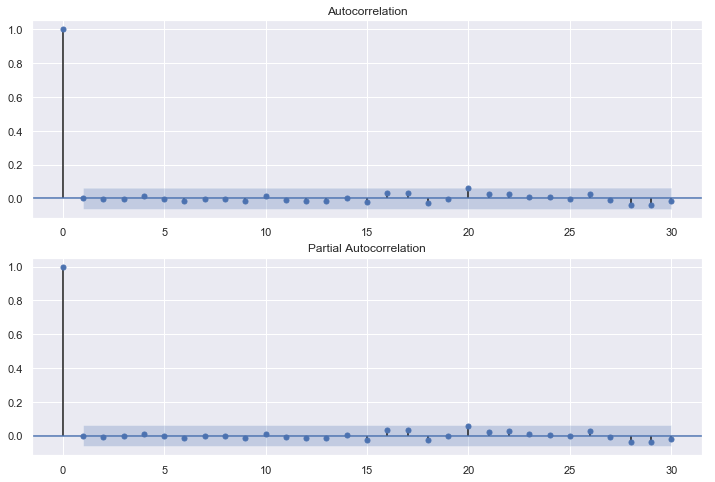

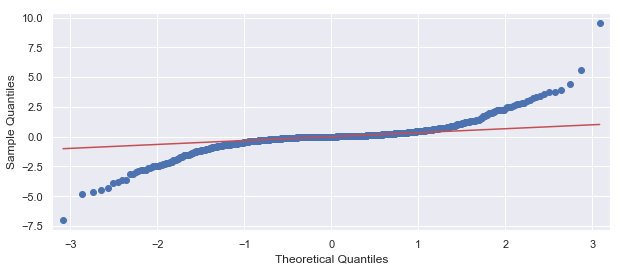

In [31]:
# resid
arima_two_aic_resid = arima_two_aic_result.resid
arima_two_aic_result_ct = ts.adfuller(arima_two_aic_resid, regression='ct', autolag='AIC')

# 输出格式解析
t = arima_two_aic_result_ct
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

# 自相关与偏自相关
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_two_aic_resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_two_aic_resid, lags=30, ax=ax2)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
fig = qqplot(arima_two_aic_resid, line='q', ax=ax, fit=True)

p_value = acorr_ljungbox(arima_two_aic_resid, lags=30)[1]
print(p_value)

                               value
Test Statistic Value        -31.2022
p-value                            0
Lags Used                          0
Number of Observations Used      977
Critical Value(1%)          -3.96807
Critical Value(5%)          -3.41499
Critical Value(10%)          -3.1297
[0.98531669 0.99980088 0.99996041 0.99999229 0.99854371 0.99945553
 0.99957958 0.99989536 0.99997267 0.99999163 0.99999821 0.99999949
 0.99953411 0.99977824 0.99987235 0.99994649 0.99997862 0.99998535
 0.99861575 0.84819638 0.8652873  0.88824661 0.90165585 0.89540109
 0.91574031 0.92316057 0.94246905 0.94880226 0.96225511 0.96071068]


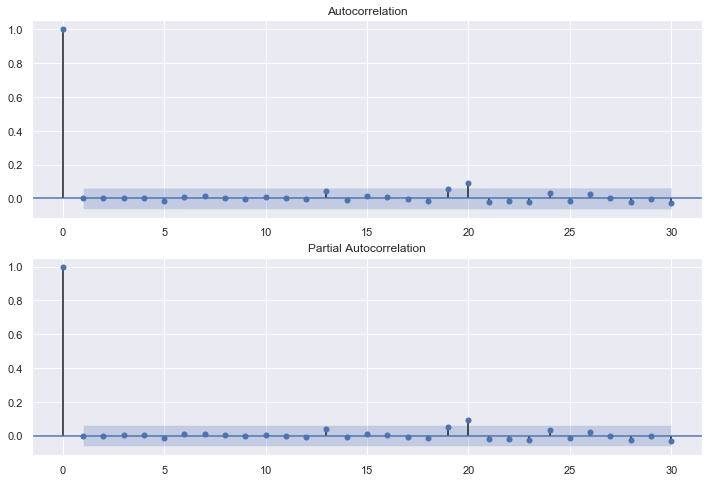

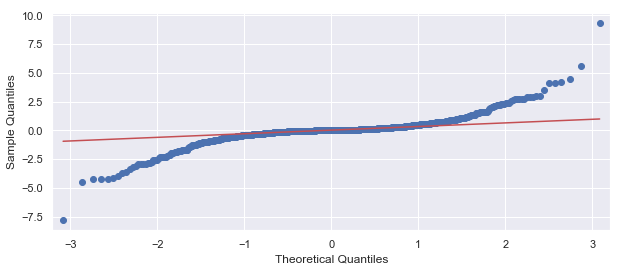

In [32]:
# resid
arima_two_bic_resid = arima_two_bic_result.resid
arima_two_bic_result_ct = ts.adfuller(arima_two_bic_resid, regression='ct', autolag='AIC')

# 输出格式解析
t = arima_two_bic_result_ct
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

# 自相关与偏自相关

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_two_bic_resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_two_bic_resid, lags=30, ax=ax2)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
fig = qqplot(arima_two_bic_resid, line='q', ax=ax, fit=True)

p_value = acorr_ljungbox(arima_two_bic_resid, lags=30)[1]
print(p_value)

In [33]:
predict_two_aic = arima_two_aic_result.predict(start = 2, end = 1052)   
predict_two_bic = arima_two_bic_result.predict(start = 2, end = 1052) 

# fig = plt.figure(figsize = (15,9))
# plt.plot(predict_two_aic)            
# fig = plt.figure(figsize = (15,9))
# plt.plot(predict_two_bic)

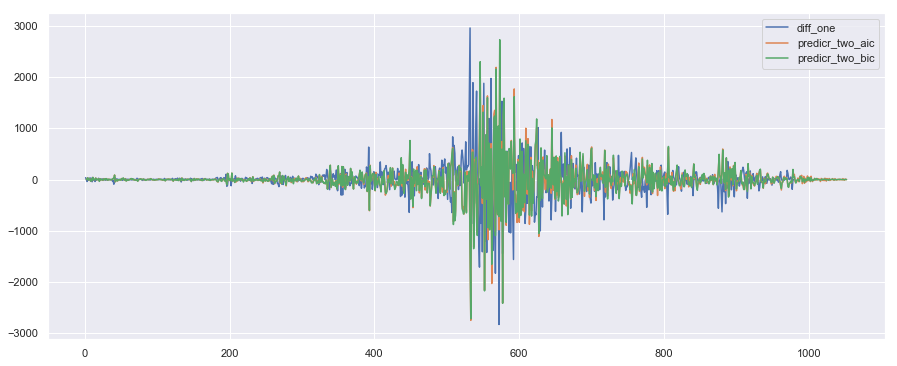

In [34]:
# 证明对称性于 diff_two_predict diff_one
# arima_two_result = ARIMA(diff_one, order=(13,1,7)).fit(disp=-1, method = 'css-mle')
# predict_two = arima_two_result.predict()
fig = plt.figure(figsize = (15,6))
l1, = plt.plot(diff_one)
l2, = plt.plot(predict_two_aic)
l3, = plt.plot(predict_two_bic)
plt.legend(handles=[l1, l2, l3], labels=['diff_one', 'predicr_two_aic', 'predicr_two_bic'])
# 得到一种特殊形式的差分

二阶AIC还原

In [58]:
ordinary = usd_time['USD'].shift(1)
ordinary = ordinary.fillna(usd_time['USD'][0]) 
# print(predict_one_shift)

# diff_one_recover = usd_time['USD'].add(predict_one_shift)
# 原始数据取对数
# y_log = np.log(usd_time['USD'])
# print(y_log)
#------------------------------------------
########## ndarray内含 
########## 0值后形成新的数据结构 
########## 0值变为NaN
#------------------------------------------
# 双数组循环
# 最终预测值

# 一阶差分还原
diff_glue_aic = {'diff_one': diff_one, 'predict': predict_two_aic} 
diff_glue_aic = pd.DataFrame(data = diff_glue_aic)
diff_glue_aic = diff_glue_aic.fillna(0)
for i, r in diff_glue_aic.iterrows():
    if diff_glue_aic.loc[i, 'diff_one'] == 0:
        diff_glue_aic.loc[i, 'diff_one'] = diff_glue_aic.loc[i-1, 'diff_one'] + diff_glue_aic.loc[i, 'predict']
    else:
        continue
        
# print(diff_glue_aic)
diff_glue_aic_re = pd.DataFrame()

# diff_glue_aic_re = diff_glue_aic['diff_one'].add(diff_glue_aic['predict'])
# huge mistake
# re_diff
diff_glue_aic_re = diff_glue_aic['diff_one']
# print(diff_glue_aic_re)

# 原数据还原
usd_glue_aic = {'ordinary' : ordinary, 'predict': diff_glue_aic_re} 
usd_glue_aic = pd.DataFrame(data = usd_glue_aic)
usd_glue_aic = usd_glue_aic.fillna(0)
for i, r in usd_glue_aic.iterrows():
    if usd_glue_aic.loc[i, 'ordinary'] == 0:
        usd_glue_aic.loc[i, 'ordinary'] = usd_glue_aic.loc[i-1, 'ordinary'] +usd_glue_aic.loc[i, 'predict']
    else:
        continue
# print(whole_data_df)
usd_glue_aic_re = pd.DataFrame()

# usd_glue_aic_re = usd_glue_aic['ordinary'].add(usd_glue_aic['predict'])
# huge mistake
# re_diff
usd_glue_aic_re = usd_glue_aic['ordinary']
# print(usd_glue_aic_re)

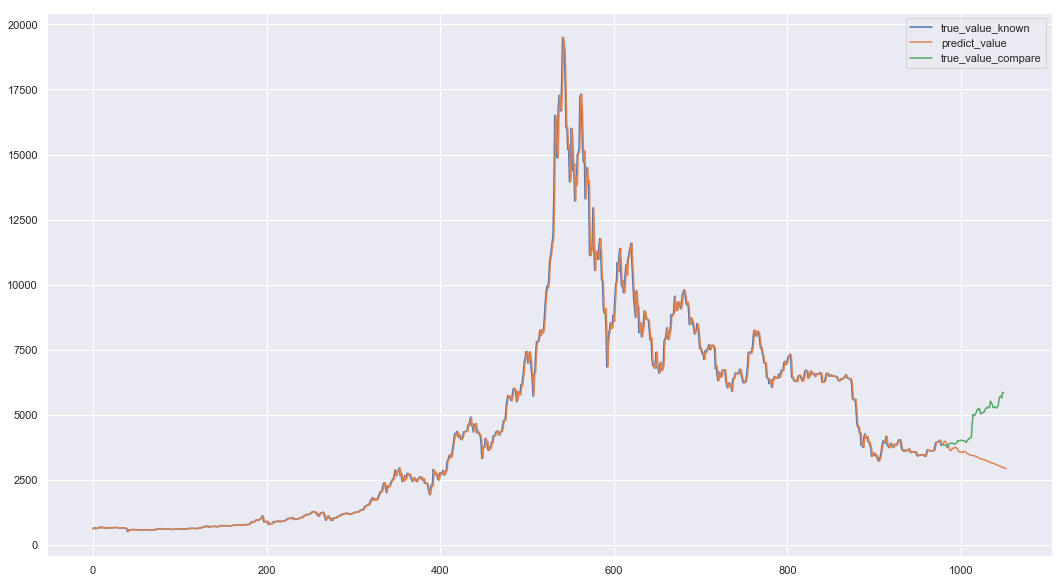

In [50]:
fig = plt.figure(figsize = (18,10))
l1, = plt.plot(y)
# 二阶差分预测
l2, = plt.plot(usd_glue_aic_re)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l1, l2, l3], labels=['true_value_known', 'predict_value', 'true_value_compare'])

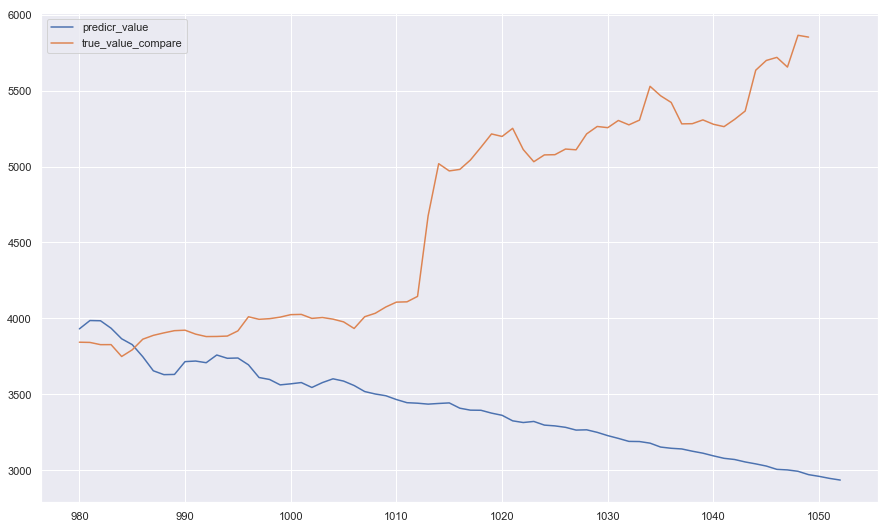

In [51]:
usd_glue_aic_re_part = usd_glue_aic_re.loc[980:]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(usd_glue_aic_re_part)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l2, l3], labels=['predicr_value', 'true_value_compare'])

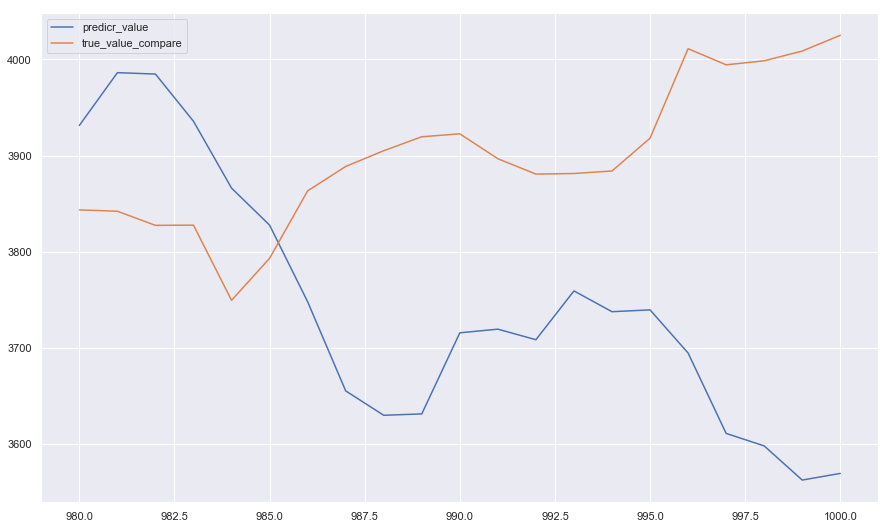

In [52]:
usd_glue_aic_re_part = usd_glue_aic_re.loc[980:1000]
true_result_slice = true_result['USD'].loc[980:1000]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(usd_glue_aic_re_part)
l3, = plt.plot(true_result_slice)
plt.legend(handles=[l2, l3], labels=['predicr_value', 'true_value_compare'])

二阶BIC还原

In [59]:
ordinary = usd_time['USD'].shift(1)
ordinary = ordinary.fillna(usd_time['USD'][0]) 
# print(predict_one_shift)

# diff_one_recover = usd_time['USD'].add(predict_one_shift)
# 原始数据取对数
# y_log = np.log(usd_time['USD'])
# print(y_log)
#------------------------------------------
########## ndarray内含 
########## 0值后形成新的数据结构 
########## 0值变为NaN
#------------------------------------------
# 双数组循环
# 最终预测值

# 一阶差分还原
diff_glue_bic = {'diff_one': diff_one, 'predict': predict_two_bic} 
diff_glue_bic = pd.DataFrame(data = diff_glue_bic)
diff_glue_bic = diff_glue_bic.fillna(0)
for i, r in diff_glue_bic.iterrows():
    if diff_glue_bic.loc[i, 'diff_one'] == 0:
        diff_glue_bic.loc[i, 'diff_one'] = diff_glue_bic.loc[i-1, 'diff_one'] + diff_glue_bic.loc[i, 'predict']
    else:
        continue
# print(diff_glue_bic)
diff_glue_bic_re = pd.DataFrame()

# diff_glue_bic_re = diff_glue_bic['diff_one'].add(diff_glue_bic['predict'])
# huge mistake 
# re_diff
diff_glue_bic_re = diff_glue_bic['diff_one']
# print(diff_glue_bic_re)

# 原数据还原
usd_glue_bic = {'ordinary' : ordinary, 'predict': diff_glue_bic_re} 
usd_glue_bic = pd.DataFrame(data = usd_glue_bic)
usd_glue_bic = usd_glue_bic.fillna(0)
for i, r in usd_glue_bic.iterrows():
    if usd_glue_bic.loc[i, 'ordinary'] == 0:
        usd_glue_bic.loc[i, 'ordinary'] = usd_glue_bic.loc[i-1, 'ordinary'] +usd_glue_bic.loc[i, 'predict']
    else:
        continue
# print(whole_data_df)
usd_glue_bic_re = pd.DataFrame()

# usd_glue_bic_re = usd_glue_bic['ordinary'].add(usd_glue_bic['predict'])
# huge mistake 
# re_diff
usd_glue_bic_re = usd_glue_bic['ordinary']

# print(usd_glue_bic_re)

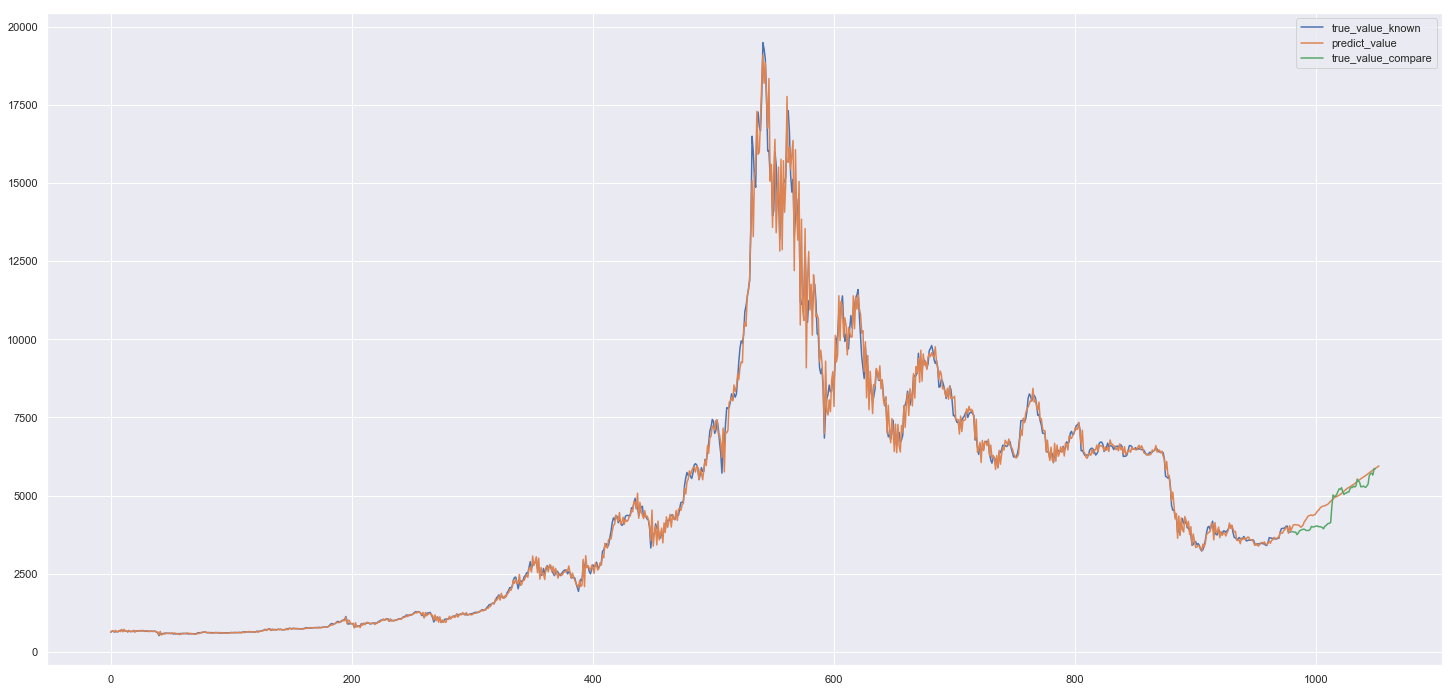

In [28]:
fig = plt.figure(figsize = (25,12))
l1, = plt.plot(y)
# 二阶差分预测
l2, = plt.plot(usd_glue_bic_re)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l1, l2, l3], labels=['true_value_known', 'predict_value', 'true_value_compare'])

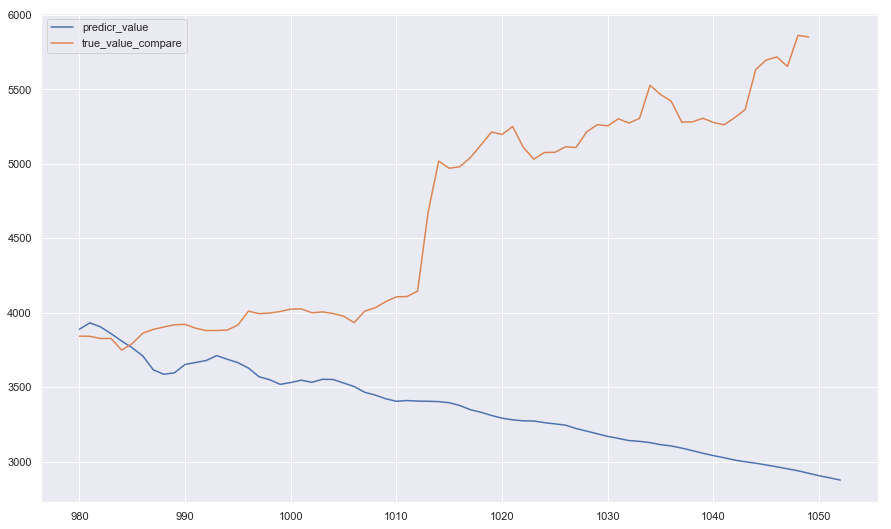

In [47]:
usd_glue_bic_re_part = usd_glue_bic_re.loc[980:]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(usd_glue_bic_re_part)
l3, = plt.plot(true_result['USD'])
plt.legend(handles=[l2, l3], labels=['predicr_value', 'true_value_compare'])

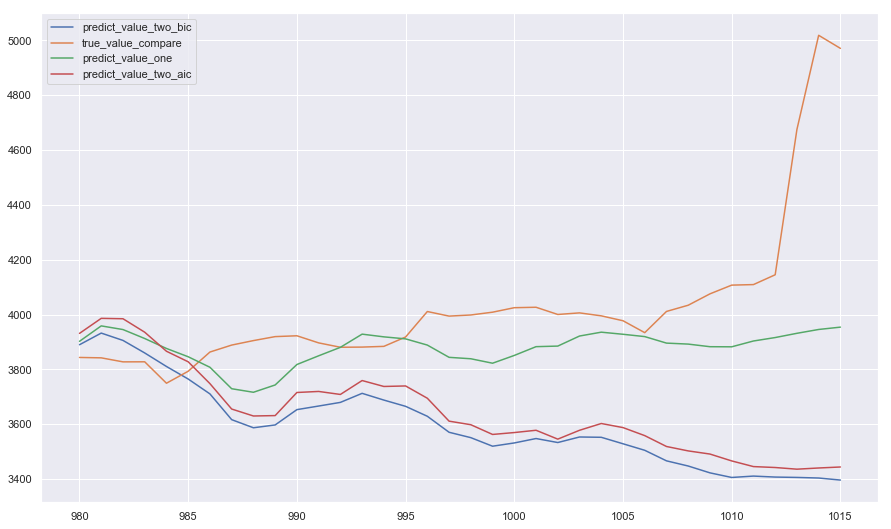

In [60]:
usd_glue_bic_re_part = usd_glue_bic_re.loc[980:1015]
true_result_slice = true_result['USD'].loc[980:1015]
diff_one_re_part_two = diff_one_re.loc[980:1015]
usd_glue_aic_re_part_two = usd_glue_aic_re.loc[980:1015]
# 拟合展示
fig = plt.figure(figsize = (15,9))
l2, = plt.plot(usd_glue_bic_re_part)
l3, = plt.plot(true_result_slice)
l4, = plt.plot(diff_one_re_part_two)
l5, = plt.plot(usd_glue_aic_re_part_two)
plt.legend(handles=[l2, l3, l4, l5], labels=['predict_value_two_bic', 'true_value_compare', 'predict_value_one','predict_value_two_aic'])